# Funcioes Utiles

In [13]:
%%writefile utils_code.py
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit #to print the circuit
from cirq.contrib.svg import circuit_to_svg
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
from cirq.circuits import InsertStrategy
from cairosvg import svg2png
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.datasets import make_imbalance
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Utils Function
def plot_history_list(list_models, name = "QNN_asd"):
    def mean_metric(list_models,metric):
        return [ np.mean([list_models[index].history[metric][jndex] for index, _ in enumerate(list_models)]) for jndex,_ in enumerate(list_models[0].history[metric])]
    plt.plot( mean_metric(list_models,'accuracy') )
    plt.plot( mean_metric(list_models,'val_accuracy'))
    plt.title(name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    #plt.savefig('/content/{}_acc.png'.format(name))
    plt.show()
    plt.plot( mean_metric(list_models,'loss') )
    plt.plot( mean_metric(list_models,'val_loss'))
    plt.title(name+': Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/content/{}_loss.png'.format(name))
    plt.grid()
    plt.show()
    def print_metric(list_models,metric):
      print(metric)
      vals =  [ list_models[index].history[metric][-1] for index, _ in enumerate(list_models) ]
      print(vals)
      print( "mean:", np.mean(vals) )
      print( "devest:", np.std(vals) )
    print_metric(list_models,'accuracy')
    print_metric(list_models,'val_accuracy')
    print_metric(list_models,'loss')
    print_metric(list_models,'val_loss') 


def prepare_ZFeatureMap(x, reps=1):
    q = cirq.GridQubit.rect(1, len(x)) 
    ops1 = [cirq.H.on(q[i]) for i in range(len(x))] 
    ops2 = [cirq.ZPowGate(exponent= (1/np.pi) * x[i]).on(q[i]) for i in range(len(x))] 
    ops_t = [ops1,ops2]*reps
    circuit = cirq.Circuit(ops_t)

    return circuit

def prepare_ZZFeatureMap(x, entanglement='linear', reps=1):
    q = cirq.GridQubit.rect(1, len(x)) 
    # entanglement
    num_qubits = len(x)
    if entanglement == 'linear':
        ret = [[i, i + 1] for i in range(num_qubits - 1)]
    elif entanglement == 'full':
        ret = [[i, j] for i in range(num_qubits) for j in range(i + 1, num_qubits)]
    else:
        raise Exception("Entanglement not found")

    ops1 = [cirq.H.on(q[i]) for i in range(len(x))] 
    ops2 = [cirq.ZPowGate(exponent= (1/np.pi) * x[i]).on(q[i]) for i in range(len(x))] 
    ops_t = [ops1,ops2]

    model_circuit = cirq.Circuit(ops_t)
    
    for j in range(reps):
        for k in ret:
            model_circuit.append([cirq.CNOT(q[k[0]], q[k[1]]),cirq.ZPowGate(exponent= (1/np.pi) *(np.pi - x[k[1]]) * (np.pi - x[k[0]])).on(q[k[1]]), cirq.CNOT(q[k[0]], q[k[1]])], strategy=InsertStrategy.EARLIEST)
        for i in range(num_qubits):
            if i == 0:
                model_circuit.append([cirq.H.on(q[i])], strategy=InsertStrategy.NEW)
            else: 
                model_circuit.append([cirq.H.on(q[i])], strategy=InsertStrategy.INLINE)
        for i in range(num_qubits):
            if i == 0:
                model_circuit.append([cirq.ZPowGate(exponent= (1/np.pi) * x[i]).on(q[i])], strategy=InsertStrategy.NEW)
            else: 
                model_circuit.append([cirq.ZPowGate(exponent= (1/np.pi) * x[i]).on(q[i])], strategy=InsertStrategy.EARLIEST)

    return model_circuit

# Circuits Parametizers
def RealAmplitudes(num_qubits=1, entanglement='linear', reps=3):
    q = cirq.GridQubit.rect(1, num_qubits)
    params = sympy.symbols(' '.join([f"gamma_{i}" for i in range(num_qubits + num_qubits*reps)])) 

    if entanglement == 'linear':
        ret = [[i, i + 1] for i in range(num_qubits - 1)]
    elif entanglement == 'full':
        ret = [[i, j] for i in range(num_qubits) for j in range(i + 1, num_qubits)]
    else:
        raise Exception("Entanglement not found")

    model_circuit = cirq.Circuit()
    for i in range(num_qubits):
        model_circuit.append([cirq.ry(params[i]).on(q[i])], strategy=InsertStrategy.EARLIEST)

    for j in range(reps):
        for k in ret:
            model_circuit.append([cirq.CNOT(q[k[0]], q[k[1]])], strategy=InsertStrategy.EARLIEST)
        for i in range(num_qubits):
            if i == 0:
                model_circuit.append([cirq.ry(params[(j+1)*num_qubits + i]).on(q[i])], strategy=InsertStrategy.NEW)
            else:  
                model_circuit.append([cirq.ry(params[(j+1)*num_qubits + i]).on(q[i])], strategy=InsertStrategy.INLINE)
    return model_circuit

def EfficientSU2(num_qubits=1, entanglement='linear', reps=3):
    q = cirq.GridQubit.rect(1, num_qubits)
    params_theta = sympy.symbols(' '.join([f"theta_{i}" for i in range(num_qubits + num_qubits*reps)])) 
    params_phi = sympy.symbols(' '.join([f"phi_{i}" for i in range(num_qubits + num_qubits*reps)])) 

    if entanglement == 'linear':
        ret = [[i, i + 1] for i in range(num_qubits - 1)]
    elif entanglement == 'full':
        ret = [[i, j] for i in range(num_qubits) for j in range(i + 1, num_qubits)]
    else:
        raise Exception("Entanglement not found")

    model_circuit = cirq.Circuit()
    for i in range(num_qubits):
        model_circuit.append([cirq.ry(params_theta[i]).on(q[i])], strategy=InsertStrategy.EARLIEST)
        model_circuit.append([cirq.rz(params_phi[i]).on(q[i])], strategy=InsertStrategy.EARLIEST)

    for j in range(reps):
        for k in ret:
            model_circuit.append([cirq.CNOT(q[k[0]], q[k[1]])], strategy=InsertStrategy.EARLIEST)
        for i in range(num_qubits):
            if i == 0:
                model_circuit.append([cirq.ry(params_theta[(j+1)*num_qubits + i]).on(q[i])], strategy=InsertStrategy.NEW)
            else:  
                model_circuit.append([cirq.ry(params_theta[(j+1)*num_qubits + i]).on(q[i])], strategy=InsertStrategy.INLINE)
        for i in range(num_qubits):
            if i == 0:
                model_circuit.append([cirq.ry(params_phi[(j+1)*num_qubits + i]).on(q[i])], strategy=InsertStrategy.INLINE)
            else:  
                model_circuit.append([cirq.ry(params_phi[(j+1)*num_qubits + i]).on(q[i])], strategy=InsertStrategy.INLINE)
    return model_circuit

def conv_layer(param, q1, q2):
    ops = []
    params = sympy.symbols(" ".join([str(param)+str(i) for i in range(3)] ))
    #  cirq.rz(params_phi[i]).on(q[i])
    #  cirq.CNOT(q[k[0]], q[k[1]])]
    ops.append( cirq.rz(-np.pi / 2).on(q2) )
    ops.append( cirq.CNOT(q2, q1)          )
    ops.append( cirq.rz(params[0]).on(q1)  )
    ops.append( cirq.ry(params[1]).on(q2)  )
    ops.append( cirq.CNOT(q1, q2)          )
    ops.append( cirq.ry(params[2]).on(q2)  )
    ops.append( cirq.CNOT(q2, q1)          )
    ops.append( cirq.rz(np.pi / 2).on(q1)  )
    return ops

def pool_layer(param, q1, q2):
    ops = []
    params = sympy.symbols(" ".join([str(param)+str(i) for i in range(3)] ))
    ops.append( cirq.rz(-np.pi / 2).on(q2)  )
    ops.append( cirq.CNOT(q2, q1)           )
    ops.append( cirq.rz(params[0]).on(q1)   )
    ops.append( cirq.ry(params[1]).on(q2)   )
    ops.append( cirq.CNOT(q1, q2)           )
    ops.append( cirq.ry(params[2]).on(q2)   )
    return ops

def QuantumConv(num_qubits=1 , reps=1,  qubits_out=3):
    assert num_qubits > qubits_out
    q = cirq.GridQubit.rect(1, num_qubits)
    # Entanglements of all num_qubits
    ret1 = [[i, j] for i in range(num_qubits) for j in range(i + 1, num_qubits)]
    
    # Entanglements of  num_qubits with qubits_out
    retp = [[i, j] for i in range(qubits_out) for j in range(qubits_out, num_qubits)]
    
    # Entanglements of all qubits_out
    ret2 = [[i, j] for i in range(qubits_out) for j in range(i + 1, qubits_out)]

    params = sympy.symbols(' '.join([f"Kappa_{i}" for i in range(len(ret1)*reps + len(ret2)*reps + len(ret2)*reps + len(retp) )])) 

    model_circuit = cirq.Circuit()
    parameter_count = 0
    for j in range(reps):
        for k in ret1:
            model_circuit.append(conv_layer(params[parameter_count], q[k[0]], q[k[1]]), strategy=InsertStrategy.NEW)
            parameter_count += 1
    
    for k in retp:
      model_circuit.append( pool_layer(params[parameter_count], q[k[1]], q[k[0]]) , strategy=InsertStrategy.NEW)
      parameter_count += 1

    for j in range(reps):
        for k in ret2:
            model_circuit.append(conv_layer(params[parameter_count], q[k[0]], q[k[1]]), strategy=InsertStrategy.NEW)
            parameter_count += 1

    return model_circuit
    

Overwriting utils_code.py


In [14]:
#read_data = prepare_ZFeatureMap
#ansatz = RealAmplitudes
classes = 0
#nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])

#x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)
def Train_model_with(read_data= prepare_ZFeatureMap,
                     ansatz = RealAmplitudes, 
                     nn= tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')]),
                     epochs = 150,
                     model_times = 3,
                     data_splitted = (x_train, x_test, y_train, y_test ) ):
    (x_train, x_test, y_train, y_test ) = data_splitted
    x_train_q = [read_data(x,reps = 3) for x in x_train]
    x_test_q = [read_data(x,reps = 3) for x in x_test]
    model_circuit = ansatz(num_qubits=5, reps=10)#), qubits_out=3)
    circuit_input = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuits_input')
    q = cirq.GridQubit.rect(1, 5)
    measurement_ops = [cirq.Z(q[i]) for i in range(5) ] 
    circuit_layer = tfq.layers.PQC(model_circuit, measurement_ops)


    model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)) )

    print(model.summary())
    list_models = []

    # metrics
    f1_list = []
    precision_list = []
    recall_list = []
    accuracy_list = []

    for i in range(model_times):
        model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)) )
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        history = model.fit(x = tfq.convert_to_tensor(x_train_q), y = y_train, epochs = epochs, verbose = 1, validation_data= (tfq.convert_to_tensor(x_test_q),y_test) )
        list_models.append(history)

        y_pred = model.predict(tfq.convert_to_tensor(x_test_q))
        f1_score = sklearn.metrics.f1_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        precision_score = sklearn.metrics.precision_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        recall_score = sklearn.metrics.recall_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        accuracy_score = sklearn.metrics.accuracy_score(y_test.argmax( axis=1), y_pred.argmax( axis=1))
        f1_list.append( f1_score )
        precision_list.append( precision_score )
        recall_list.append( recall_score )
        accuracy_list.append( accuracy_score )

    plot_history_list(list_models,name="QNN Hybrid {}".format(name_dataset) )

    print("f1 :", f1_list)
    print("f1 average:", np.mean(f1_list) )
    print("Precision :", precision_list)
    print("precision average:", np.mean(precision_list) )
    print("Recall :", recall_list)
    print("recall average:", np.mean(recall_list) )
    print("Accuracy :", accuracy_list)
    print("accuracy average:", np.mean(accuracy_list) )
    model.evaluate(tfq.convert_to_tensor(x_test_q), y_test)
    cm = confusion_matrix(y_test.argmax( axis=1), y_pred.argmax( axis=1), normalize='true')

    if classes == 3:  
        ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],yticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],)
    else:

        ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=range(classes),yticklabels=range(classes))
    
    ax.set_title('{} Confusion Matrix'.format(name_dataset));
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label');
    #plt.savefig('/content/{}_CM.png'.format(name_dataset))
    plt.show()
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")

# Imports

In [15]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.circuits import InsertStrategy
# from cirq.contrib.svg import SVGCircuit #to print the circuit
# from cirq.contrib.svg import circuit_to_svg
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
from cairosvg import svg2png
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.datasets import make_imbalance
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from utils_code import prepare_ZFeatureMap, QuantumConv, RealAmplitudes, prepare_ZZFeatureMap, plot_history_list

# CWRU - 3 Clases

In [16]:
!ls

content		       CWRU_3Classes.npz  myenv        utils_code.py
Create_model.ipynb     CWRU.ipynb	  pu_2.npz
Create_model_pu.ipynb  hol.py		  PU.ipynb
cwru_2.npz	       mfpt_2.npz	  __pycache__


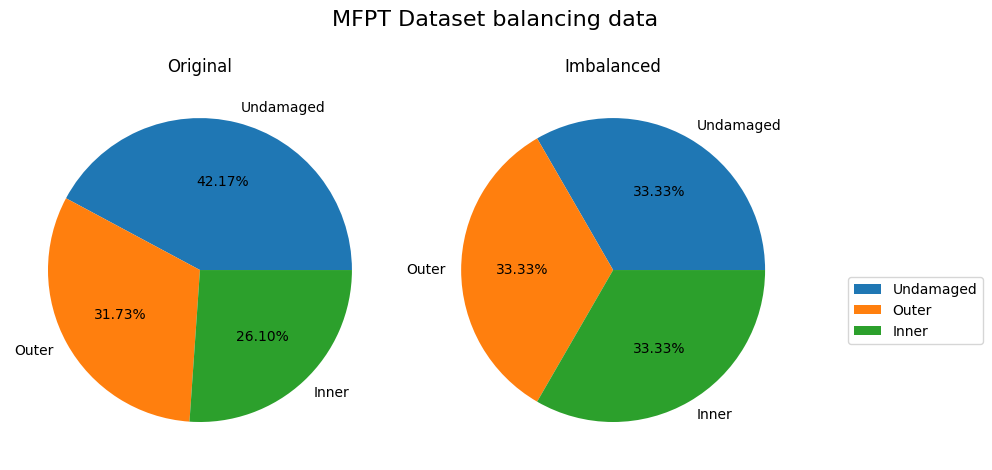

In [17]:
file_read = "mfpt_2.npz"  #  pu_2.npz cwru_2.npz
name_dataset = "MFPT Dataset" #"PU", "CWRU"
data_load = np.load(file_read)
try:
  X, y = data_load["x"], data_load["y"]
except:
  X, y = data_load["data"], data_load["label"]


min_samples_label =  min([sum(y == i)  for i in range(3) ])
sampling_strategy = {0: min_samples_label, 
                     1: min_samples_label, 
                     2: min_samples_label}
X, y = make_imbalance(X, y, sampling_strategy=sampling_strategy)
X = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

labels = "Undamaged", "Outer", "Inner"
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = f"%.2f%%"
try:
    pd.DataFrame( data_load["y"]).value_counts().plot.pie(autopct=autopct, labels=labels, ax=axs[0], ylabel="")
except:
    pd.DataFrame( data_load["label"]).value_counts().plot.pie(autopct=autopct, labels=labels, ax=axs[0], ylabel="")
axs[0].set_title("Original")
pd.DataFrame( y ).value_counts().plot.pie(autopct=autopct, labels=labels,  ax=axs[1], ylabel="")
axs[1].set_title("Imbalanced")
plt.legend(labels,bbox_to_anchor=(1.1,0.5) )

fig.suptitle("{} balancing data".format(name_dataset), fontsize=16)
fig.tight_layout()

y = y.astype(int)
# Code a function to perform preprocessing on the classical dataset
def prepare_classic_dataset(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
    scaler = MinMaxScaler(feature_range = (0, np.pi))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
     
    classes = len(np.unique(y))

    y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
    y_test = np.eye(classes)[y_test]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

Text(0.5, 1.0, 'MFPT Dataset')

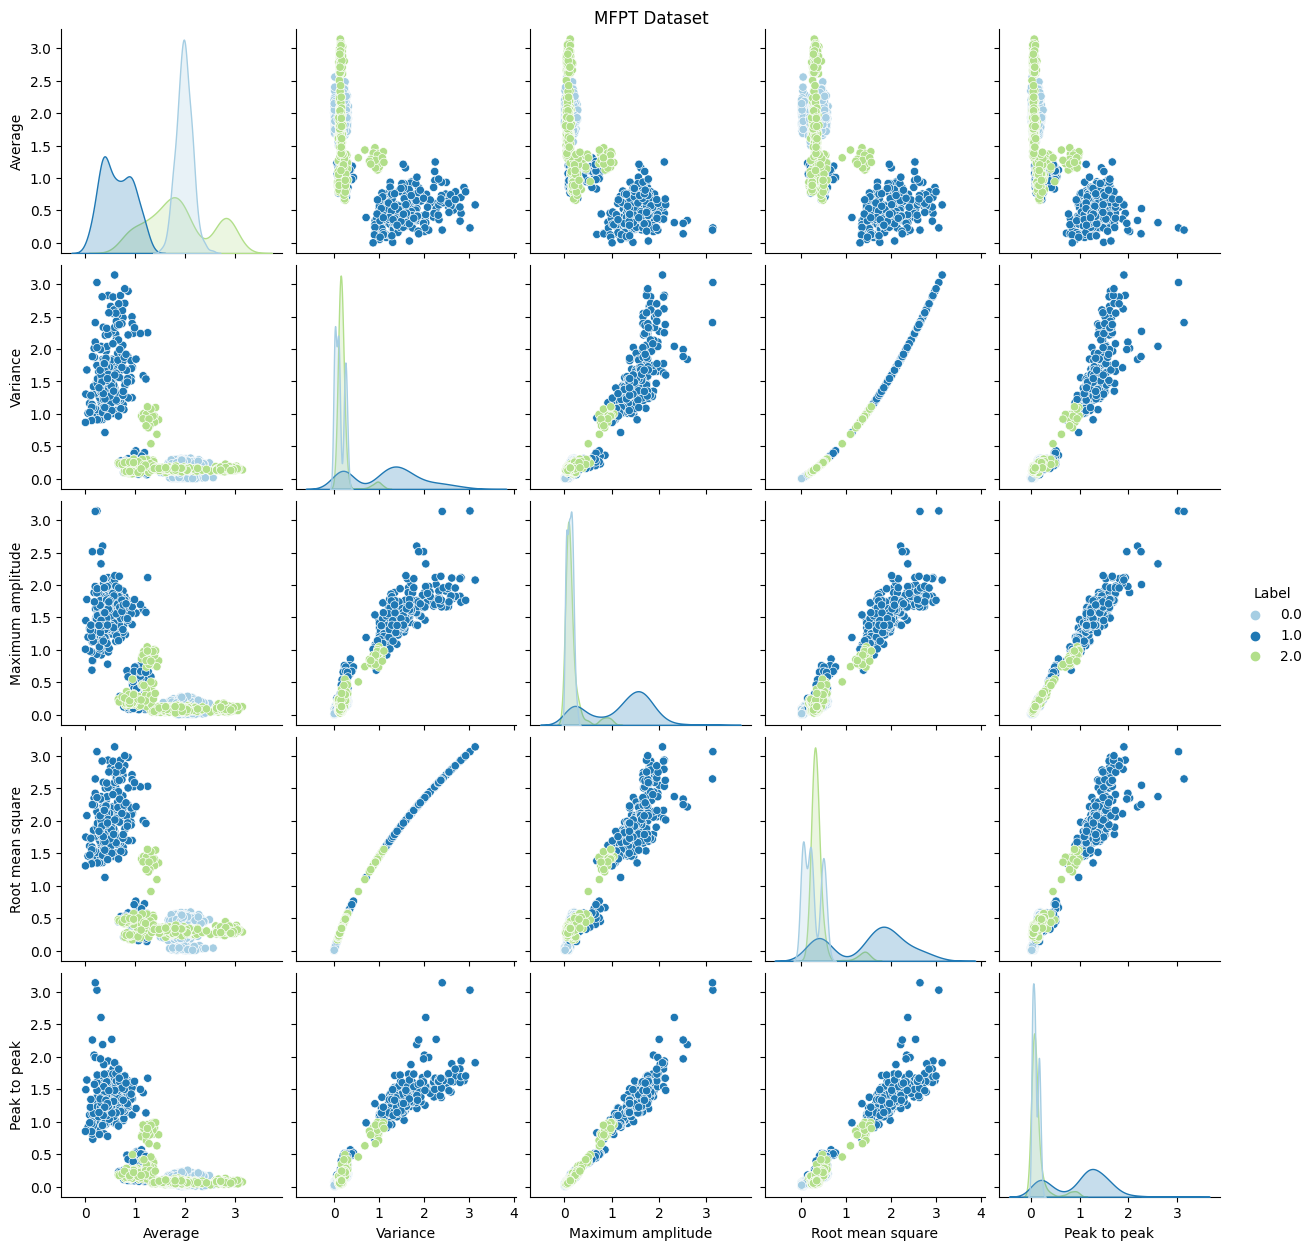

In [18]:
data_df = pd.DataFrame(np.hstack( ( X ,y.reshape(-1,1)) ), columns = ["Average","Variance","Maximum amplitude","Root mean square","Peak to peak","Label"])
p = sns.pairplot(data_df, hue = "Label", palette = "Paired")
p.fig.suptitle(name_dataset, y=1.0)

# Sin MLP

In [19]:
# Se crea una capa constante que es solo para seleccionar los 3 primeros qubits
class constant_layer(tf.keras.layers.Layer):
  def __init__(self):
    super(constant_layer, self).__init__()
  def build(self, input_shape):
    self.kernel =   tf.constant([[1,0,0],[0,1,0],[0,0,1],[0,0,0],[0,0,0]], dtype='float32')
  def call(self, inputs):
    return tf.matmul( inputs, self.kernel)
 
nn = tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc (PQC)                   (None, 5)                 55        
                                                                 
 sequential_4 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 5s 186ms/step - loss: 1.0018 - accuracy: 0.4837 - val_loss: 0.9334 - val_accuracy: 0.5117
Epoch 2/200
25/25 [==============================] - 4s 171ms/step - loss: 0.9054 - accuracy: 0.5451 - val_loss: 0.8953 - val_accuracy: 0.5146
Epoch 3/200
25/25 [===================

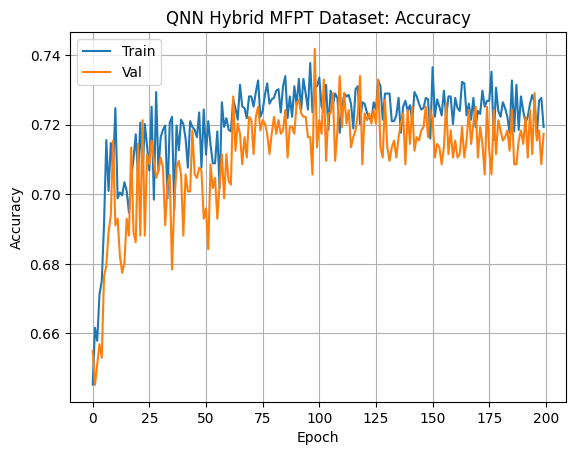

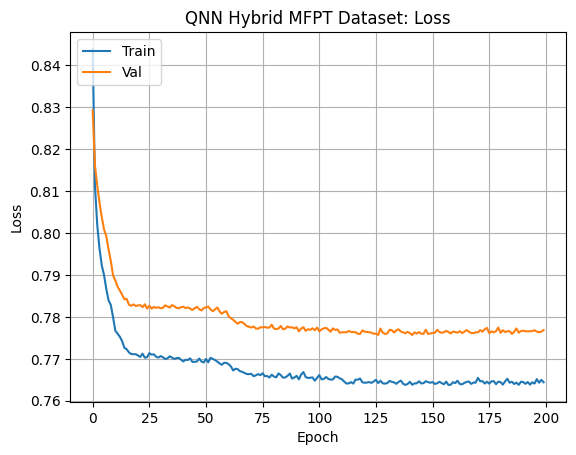

accuracy
[0.7180451154708862, 0.7230576276779175, 0.7167919874191284]
mean: 0.719298243522644
devest: 0.002707065988447802
val_accuracy
[0.7134503126144409, 0.7163742780685425, 0.7222222089767456]
mean: 0.7173489332199097
devest: 0.003646825646670311
loss
[0.7638590335845947, 0.7651852965354919, 0.7641995549201965]
mean: 0.7644146283467611
devest: 0.000562397124128082
val_loss
[0.7761844396591187, 0.7772326469421387, 0.7771344184875488]
mean: 0.7768505016962687
devest: 0.0004726811365830375
f1 : [0.7134502923976607, 0.7163742690058481, 0.7222222222222222]
f1 average: 0.7173489278752436
Precision : [0.7134502923976608, 0.716374269005848, 0.7222222222222222]
precision average: 0.7173489278752436
Recall : [0.7134502923976608, 0.716374269005848, 0.7222222222222222]
recall average: 0.7173489278752436
Accuracy : [0.7134502923976608, 0.716374269005848, 0.7222222222222222]
accuracy average: 0.7173489278752436
11/11 [==============================] - 1s 105ms/step - loss: 0.7771 - accuracy: 0.7

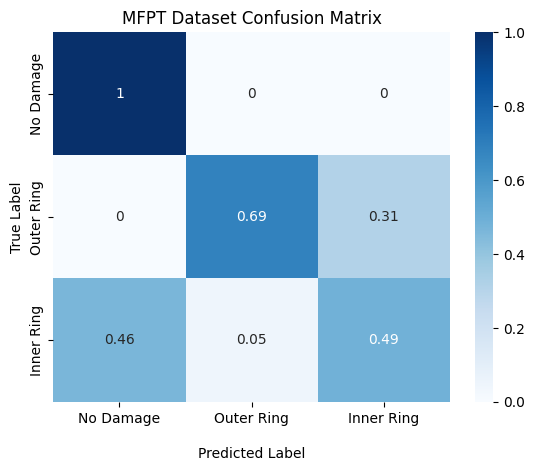

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [20]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_1 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_5 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 8s 293ms/step - loss: 1.0130 - accuracy: 0.5226 - val_loss: 0.9346 - val_accuracy: 0.6228
Epoch 2/200
25/25 [==============================] - 7s 282ms/step - loss: 0.9096 - accuracy: 0.6504 - val_loss: 0.8772 - val_accuracy: 0.7076
Epoch 3/200
25/25 [=================

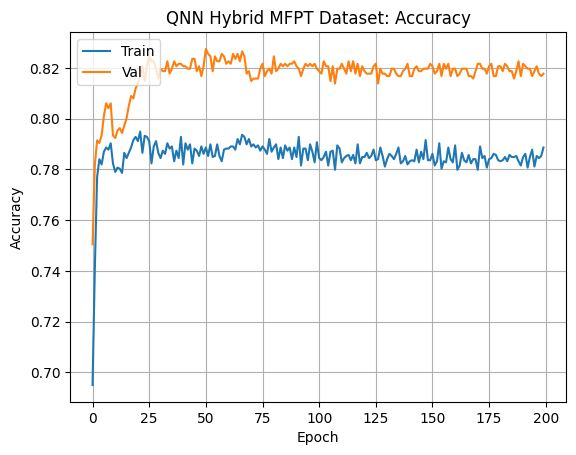

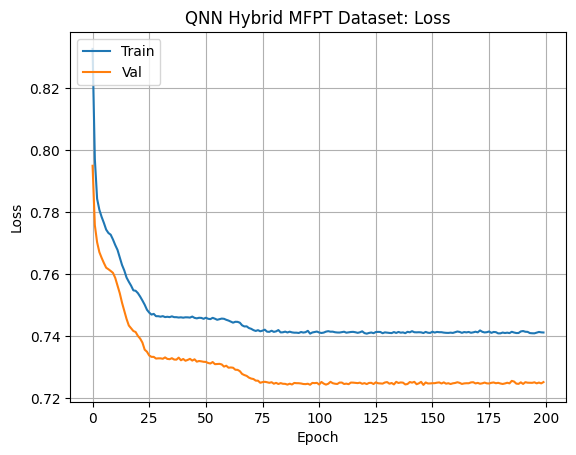

accuracy
[0.7882205247879028, 0.786967396736145, 0.7907268404960632]
mean: 0.7886382540067037
devest: 0.001562951827190457
val_accuracy
[0.8187134265899658, 0.8187134265899658, 0.8157894611358643]
mean: 0.8177387714385986
devest: 0.0013783705337002785
loss
[0.7410960793495178, 0.7408460974693298, 0.7416171431541443]
mean: 0.7411864399909973
devest: 0.00032119739119341784
val_loss
[0.7251790165901184, 0.7252668142318726, 0.7251309752464294]
mean: 0.7251922686894735
devest: 5.6242161495572226e-05
f1 : [0.8187134502923976, 0.8187134502923976, 0.8157894736842104]
f1 average: 0.8177387914230018
Precision : [0.8187134502923976, 0.8187134502923976, 0.8157894736842105]
precision average: 0.817738791423002
Recall : [0.8187134502923976, 0.8187134502923976, 0.8157894736842105]
recall average: 0.817738791423002
Accuracy : [0.8187134502923976, 0.8187134502923976, 0.8157894736842105]
accuracy average: 0.817738791423002
11/11 [==============================] - 2s 131ms/step - loss: 0.7251 - accuracy:

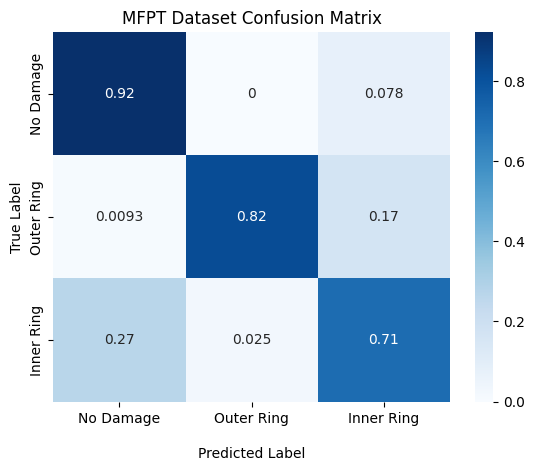

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [21]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_2 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_6 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 49s 2s/step - loss: 0.8389 - accuracy: 0.6404 - val_loss: 0.7779 - val_accuracy: 0.7749
Epoch 2/200
25/25 [==============================] - 46s 2s/step - loss: 0.7518 - accuracy: 0.7130 - val_loss: 0.7488 - val_accuracy: 0.7398
Epoch 3/200
25/25 [===================

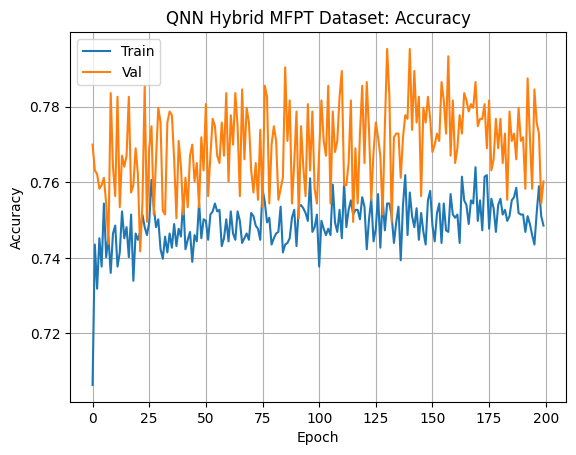

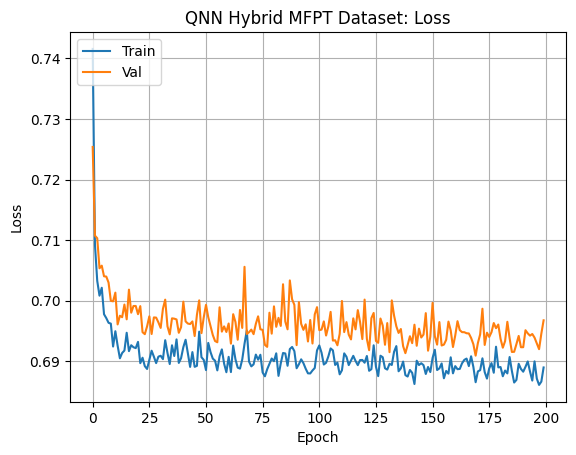

accuracy
[0.7406014800071716, 0.7493734359741211, 0.7556390762329102]
mean: 0.7485379974047343
devest: 0.006167430219278296
val_accuracy
[0.6929824352264404, 0.792397677898407, 0.7953216433525085]
mean: 0.7602339188257853
devest: 0.04756895996500877
loss
[0.6936208009719849, 0.6877813339233398, 0.6855190992355347]
mean: 0.6889737447102865
devest: 0.0034132853548275166
val_loss
[0.7066857218742371, 0.6921990513801575, 0.6913875937461853]
mean: 0.69675745566686
devest: 0.007028156149201711
f1 : [0.6929824561403509, 0.7923976608187134, 0.7953216374269005]
f1 average: 0.7602339181286549
Precision : [0.6929824561403509, 0.7923976608187134, 0.7953216374269005]
precision average: 0.7602339181286549
Recall : [0.6929824561403509, 0.7923976608187134, 0.7953216374269005]
recall average: 0.7602339181286549
Accuracy : [0.6929824561403509, 0.7923976608187134, 0.7953216374269005]
accuracy average: 0.7602339181286549
11/11 [==============================] - 9s 839ms/step - loss: 0.6914 - accuracy: 0.7

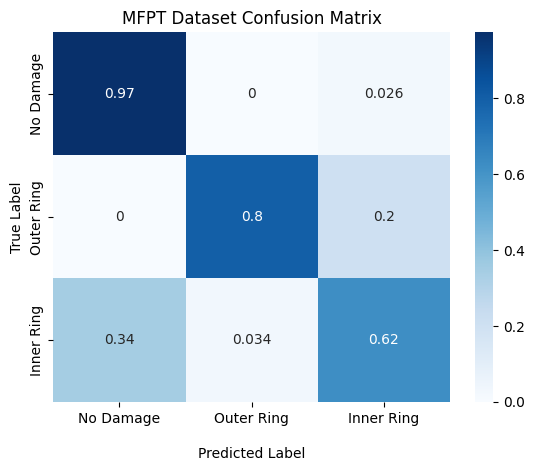

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [22]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_3 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_7 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 47s 2s/step - loss: 0.8711 - accuracy: 0.7193 - val_loss: 0.7529 - val_accuracy: 0.8509
Epoch 2/200
25/25 [==============================] - 47s 2s/step - loss: 0.7407 - accuracy: 0.8208 - val_loss: 0.7028 - val_accuracy: 0.8480
Epoch 3/200
25/25 [==================

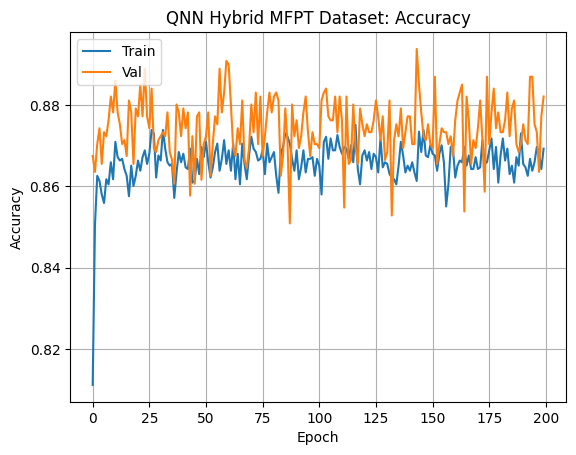

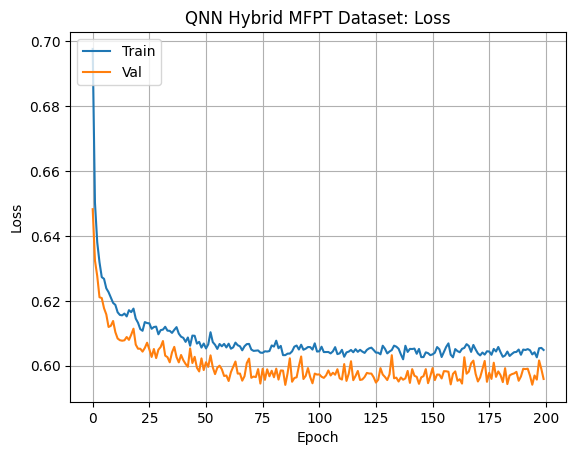

accuracy
[0.8659147620201111, 0.8746867179870605, 0.8671678900718689]
mean: 0.8692564566930135
devest: 0.003873705011118308
val_accuracy
[0.871345043182373, 0.8830409646034241, 0.8918128609657288]
mean: 0.8820662895838419
devest: 0.008384326041231585
loss
[0.6076149940490723, 0.6046594977378845, 0.6023138761520386]
mean: 0.6048627893129984
devest: 0.002168941114606688
val_loss
[0.5965466499328613, 0.5982249975204468, 0.5930356979370117]
mean: 0.5959357817967733
devest: 0.0021621096875390927
f1 : [0.8713450292397662, 0.8830409356725146, 0.8918128654970762]
f1 average: 0.882066276803119
Precision : [0.8713450292397661, 0.8830409356725146, 0.8918128654970761]
precision average: 0.882066276803119
Recall : [0.8713450292397661, 0.8830409356725146, 0.8918128654970761]
recall average: 0.882066276803119
Accuracy : [0.8713450292397661, 0.8830409356725146, 0.8918128654970761]
accuracy average: 0.882066276803119
11/11 [==============================] - 10s 945ms/step - loss: 0.5930 - accuracy: 0.8

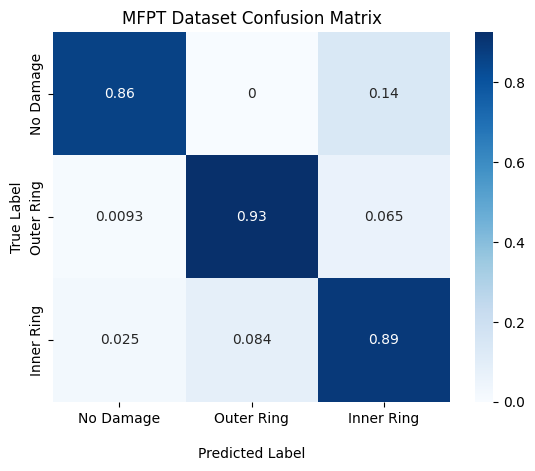

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [23]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# CON MLP

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_4 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_8 (Sequential)   (None, 3)                 903       
                                                                 
Total params: 958
Trainable params: 958
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 7s 238ms/step - loss: 0.8240 - accuracy: 0.6341 - val_loss: 0.6659 - val_accuracy: 0.6023
Epoch 2/200
25/25 [==============================] - 5s 222ms/step - loss: 0.5355 - accuracy: 0.7469 - val_loss: 0.4555 - val_accuracy: 0.7836
Epoch 3/200
25/25 [==============

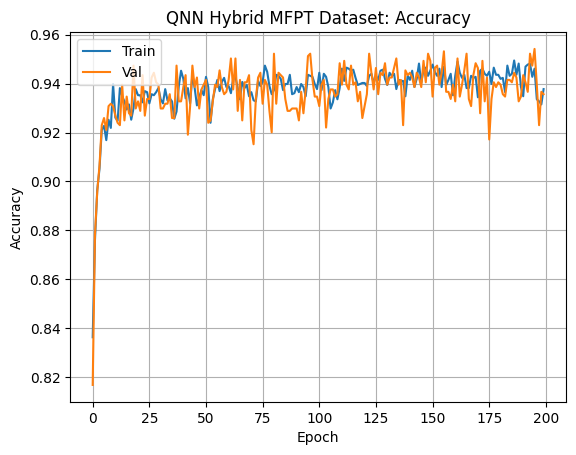

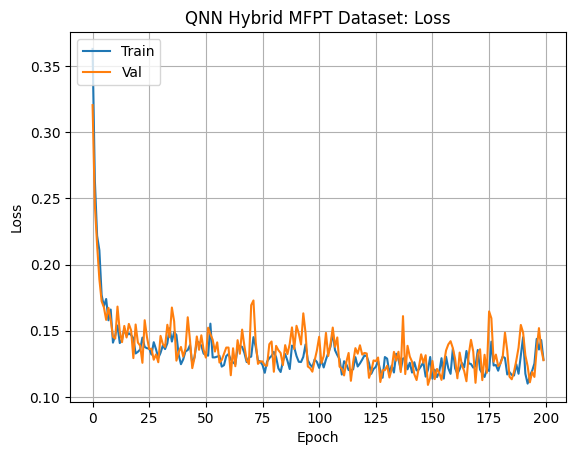

accuracy
[0.9373433589935303, 0.9436089992523193, 0.932330846786499]
mean: 0.9377610683441162
devest: 0.00461375057747652
val_accuracy
[0.9415204524993896, 0.9444444179534912, 0.9210526347160339]
mean: 0.9356725017229716
devest: 0.010406497232325682
loss
[0.12485872954130173, 0.1274959146976471, 0.1321088820695877]
mean: 0.12815450876951218
devest: 0.0029962740789715
val_loss
[0.1326325684785843, 0.11182130128145218, 0.1386650651693344]
mean: 0.12770631164312363
devest: 0.011499215037667708
f1 : [0.9415204678362573, 0.9444444444444444, 0.9210526315789473]
f1 average: 0.935672514619883
Precision : [0.9415204678362573, 0.9444444444444444, 0.9210526315789473]
precision average: 0.935672514619883
Recall : [0.9415204678362573, 0.9444444444444444, 0.9210526315789473]
recall average: 0.935672514619883
Accuracy : [0.9415204678362573, 0.9444444444444444, 0.9210526315789473]
accuracy average: 0.935672514619883
11/11 [==============================] - 1s 100ms/step - loss: 0.1387 - accuracy: 0.92

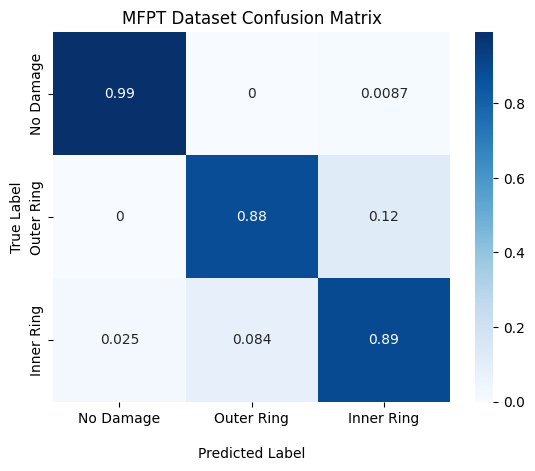

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [24]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_5 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_9 (Sequential)   (None, 3)                 903       
                                                                 
Total params: 958
Trainable params: 958
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 8s 285ms/step - loss: 0.7609 - accuracy: 0.6880 - val_loss: 0.4924 - val_accuracy: 0.8304
Epoch 2/200
25/25 [==============================] - 7s 289ms/step - loss: 0.3679 - accuracy: 0.8459 - val_loss: 0.2849 - val_accuracy: 0.8918
Epoch 3/200
25/25 [==============

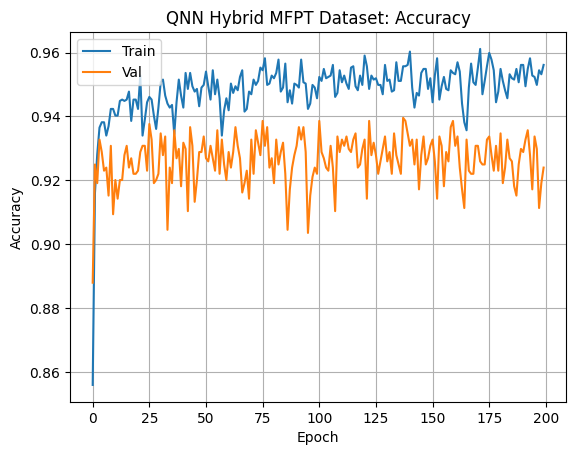

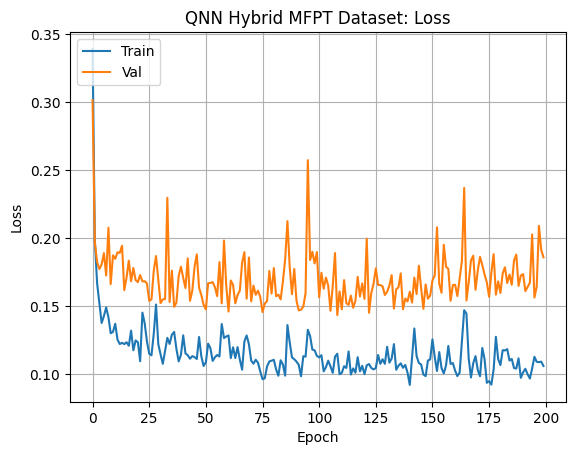

accuracy
[0.9523809552192688, 0.9611529111862183, 0.9548872113227844]
mean: 0.9561403592427572
devest: 0.0036891360916004954
val_accuracy
[0.9356725215911865, 0.9064327478408813, 0.9298245906829834]
mean: 0.9239766200383505
devest: 0.012633029795939048
loss
[0.11444440484046936, 0.09553389996290207, 0.10815440118312836]
mean: 0.10604423532883327
devest: 0.007863052784196852
val_loss
[0.17599426209926605, 0.20414097607135773, 0.17752309143543243]
mean: 0.1858861098686854
devest: 0.012923220311849054
f1 : [0.935672514619883, 0.9064327485380118, 0.9298245614035088]
f1 average: 0.9239766081871345
Precision : [0.935672514619883, 0.9064327485380117, 0.9298245614035088]
precision average: 0.9239766081871345
Recall : [0.935672514619883, 0.9064327485380117, 0.9298245614035088]
recall average: 0.9239766081871345
Accuracy : [0.935672514619883, 0.9064327485380117, 0.9298245614035088]
accuracy average: 0.9239766081871345
11/11 [==============================] - 1s 123ms/step - loss: 0.1775 - accura

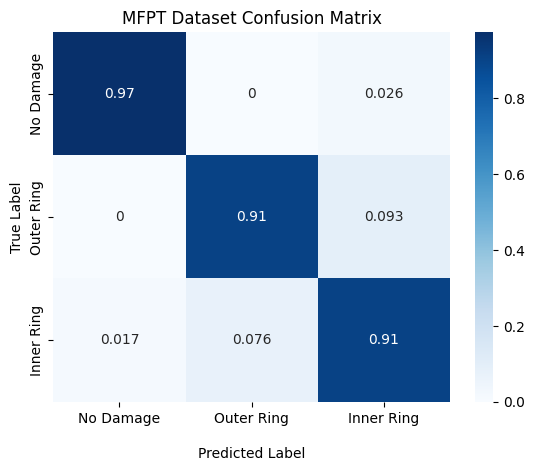

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [25]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_6 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_10 (Sequential)  (None, 3)                 903       
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 45s 2s/step - loss: 0.7456 - accuracy: 0.6228 - val_loss: 0.5518 - val_accuracy: 0.6959
Epoch 2/200
25/25 [==============================] - 47s 2s/step - loss: 0.5121 - accuracy: 0.7707 - val_loss: 0.4919 - val_accuracy: 0.7573
Epoch 3/200
25/25 [==============

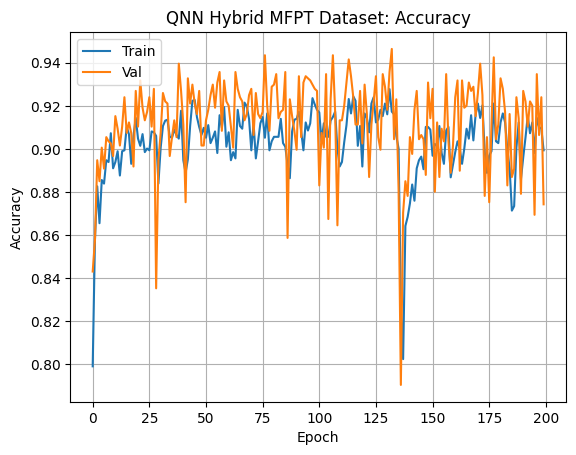

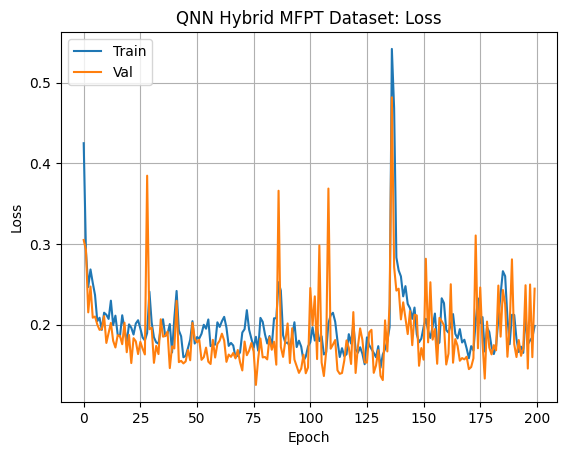

accuracy
[0.9097744226455688, 0.9035087823867798, 0.8847118020057678]
mean: 0.8993316690127054
devest: 0.010649567923584126
val_accuracy
[0.859649121761322, 0.9298245906829834, 0.8333333134651184]
mean: 0.8742690086364746
devest: 0.04072630160772775
loss
[0.18043741583824158, 0.20354826748371124, 0.2113630771636963]
mean: 0.1984495868285497
devest: 0.013130030221383605
val_loss
[0.2415667474269867, 0.17389672994613647, 0.3184870183467865]
mean: 0.24465016523996988
devest: 0.0590689905901162
f1 : [0.8596491228070176, 0.9298245614035088, 0.8333333333333334]
f1 average: 0.8742690058479532
Precision : [0.8596491228070176, 0.9298245614035088, 0.8333333333333334]
precision average: 0.8742690058479532
Recall : [0.8596491228070176, 0.9298245614035088, 0.8333333333333334]
recall average: 0.8742690058479532
Accuracy : [0.8596491228070176, 0.9298245614035088, 0.8333333333333334]
accuracy average: 0.8742690058479532
11/11 [==============================] - 10s 907ms/step - loss: 0.3185 - accuracy:

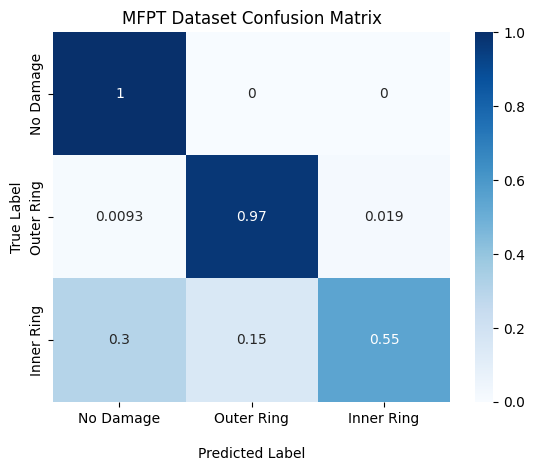

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [26]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_7 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_11 (Sequential)  (None, 3)                 903       
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
25/25 [==============================] - 51s 2s/step - loss: 0.6925 - accuracy: 0.7168 - val_loss: 0.3435 - val_accuracy: 0.8363
Epoch 2/200
25/25 [==============================] - 50s 2s/step - loss: 0.3231 - accuracy: 0.8459 - val_loss: 0.2582 - val_accuracy: 0.8977
Epoch 3/200
25/25 [==============

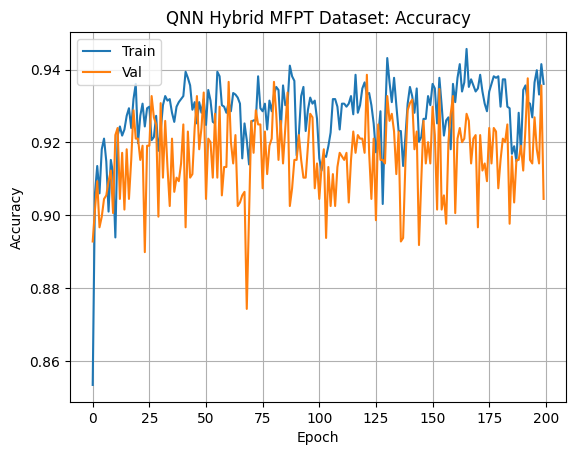

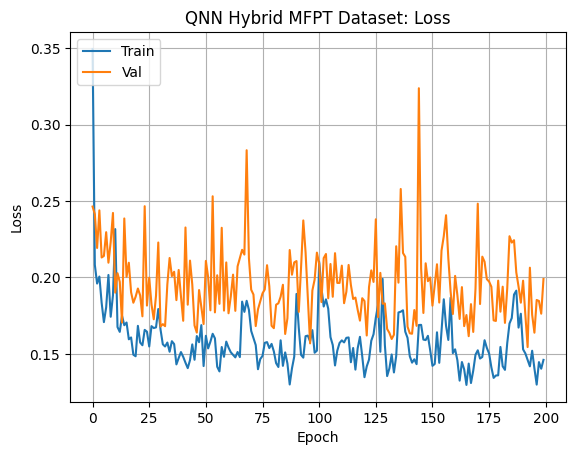

accuracy
[0.9235588908195496, 0.9448621273040771, 0.9398496150970459]
mean: 0.9360902110735575
devest: 0.00909420365352907
val_accuracy
[0.8830409646034241, 0.932748556137085, 0.8976607918739319]
mean: 0.904483437538147
devest: 0.020858611881169428
loss
[0.16685084998607635, 0.13799844682216644, 0.13336534798145294]
mean: 0.1460715482632319
devest: 0.01481442846875324
val_loss
[0.2362283617258072, 0.1443646252155304, 0.2164245992898941]
mean: 0.19900586207707724
devest: 0.03947400685661616
f1 : [0.8830409356725146, 0.9327485380116959, 0.8976608187134503]
f1 average: 0.9044834307992202
Precision : [0.8830409356725146, 0.9327485380116959, 0.8976608187134503]
precision average: 0.9044834307992202
Recall : [0.8830409356725146, 0.9327485380116959, 0.8976608187134503]
recall average: 0.9044834307992202
Accuracy : [0.8830409356725146, 0.9327485380116959, 0.8976608187134503]
accuracy average: 0.9044834307992202
11/11 [==============================] - 10s 883ms/step - loss: 0.2164 - accuracy: 

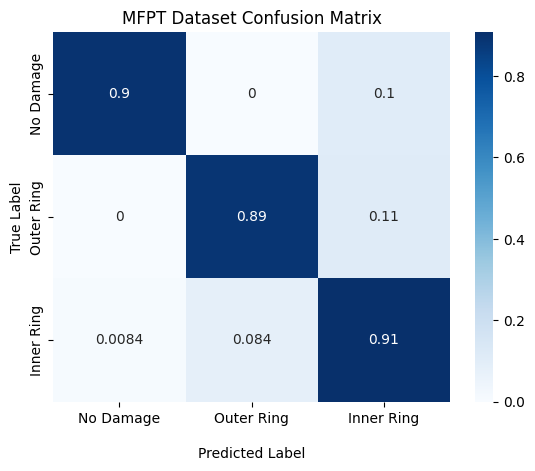

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [27]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# Only NN

Epoch 1/150
29/29 [==============================] - 1s 10ms/step - loss: 1.7863 - accuracy: 0.3363 - val_loss: 1.4134 - val_accuracy: 0.5536
Epoch 2/150
29/29 [==============================] - 0s 6ms/step - loss: 1.2333 - accuracy: 0.5893 - val_loss: 1.0136 - val_accuracy: 0.7449
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 0.9118 - accuracy: 0.7306 - val_loss: 0.7688 - val_accuracy: 0.8138
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.8302 - val_loss: 0.6536 - val_accuracy: 0.8291
Epoch 5/150
29/29 [==============================] - 0s 3ms/step - loss: 0.5684 - accuracy: 0.8631 - val_loss: 0.5449 - val_accuracy: 0.9362
Epoch 6/150
29/29 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.9058 - val_loss: 0.4774 - val_accuracy: 0.9056
Epoch 7/150
29/29 [==============================] - 0s 3ms/step - loss: 0.4274 - accuracy: 0.9157 - val_loss: 0.4417 - val_accuracy: 0.8801
Epoch 8/150


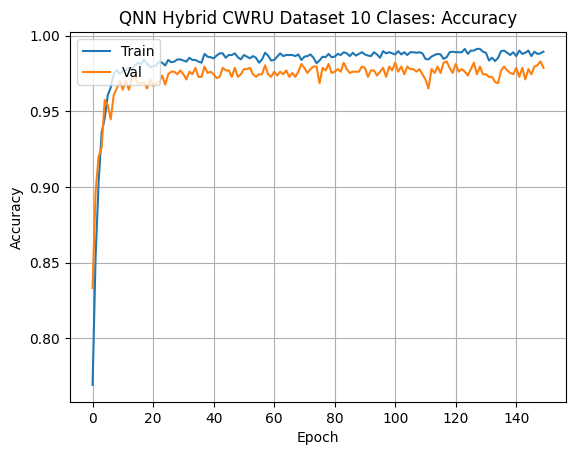

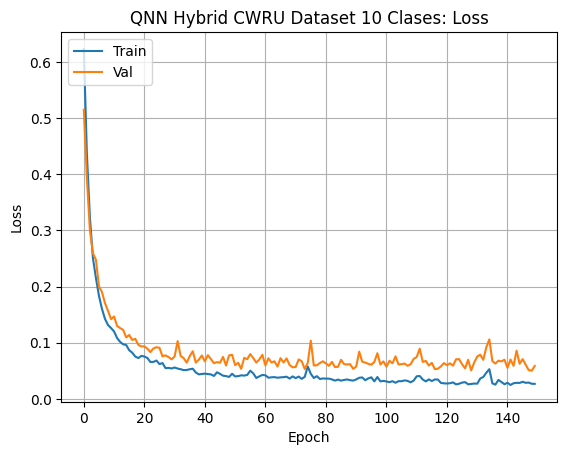

accuracy
[0.9846659302711487, 0.9901424050331116, 0.9934282302856445]
mean: 0.9894121885299683
devest: 0.0036142668682233583
val_accuracy
[0.9770408272743225, 0.9770408272743225, 0.9821428656578064]
mean: 0.9787415067354838
devest: 0.0024051239592236713
loss
[0.041579000651836395, 0.02327151596546173, 0.015408137813210487]
mean: 0.026752884810169537
devest: 0.010964137363976528
val_loss
[0.06900958716869354, 0.05494916811585426, 0.05175108462572098]
mean: 0.058569946636756264
devest: 0.00749651053622135
f1 : [0.9770408163265306, 0.9770408163265306, 0.9821428571428571]
f1 average: 0.9787414965986394
Precision : [0.9770408163265306, 0.9770408163265306, 0.9821428571428571]
precision average: 0.9787414965986394
Recall : [0.9770408163265306, 0.9770408163265306, 0.9821428571428571]
recall average: 0.9787414965986394
Accuracy : [0.9770408163265306, 0.9770408163265306, 0.9821428571428571]
accuracy average: 0.9787414965986394
13/13 [==============================] - 0s 2ms/step - loss: 0.0518 -

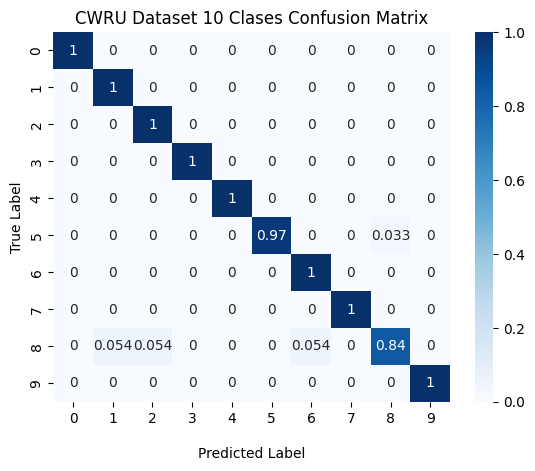

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
scaler = MinMaxScaler(feature_range = (0, 1))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
    
classes = len(np.unique(y))

y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
y_test = np.eye(classes)[y_test]

classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])

model = nn#tf.keras.Model(outputs = nn())

#print(model.summary())
list_models = []

# metrics
f1_list = []
precision_list = []
recall_list = []
accuracy_list = []
model_times = 3 
for i in range(model_times):
    model = nn#tf.keras.Model(inputs = nn(), outputs = nn() )
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(x = x_train, y = y_train, epochs = 150, verbose = 1, validation_data= (x_test,y_test) )
    list_models.append(history)

    y_pred = model.predict(x_test)
    f1_score = sklearn.metrics.f1_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    precision_score = sklearn.metrics.precision_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    recall_score = sklearn.metrics.recall_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    accuracy_score = sklearn.metrics.accuracy_score(y_test.argmax( axis=1), y_pred.argmax( axis=1))
    f1_list.append( f1_score )
    precision_list.append( precision_score )
    recall_list.append( recall_score )
    accuracy_list.append( accuracy_score )

plot_history_list(list_models,name="QNN Hybrid {}".format(name_dataset) )

print("f1 :", f1_list)
print("f1 average:", np.mean(f1_list) )
print("Precision :", precision_list)
print("precision average:", np.mean(precision_list) )
print("Recall :", recall_list)
print("recall average:", np.mean(recall_list) )
print("Accuracy :", accuracy_list)
print("accuracy average:", np.mean(accuracy_list) )
model.evaluate(x_test, y_test)
cm = confusion_matrix(y_test.argmax( axis=1), y_pred.argmax( axis=1), normalize='true')

if classes == 3:  
    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],yticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],)
else:

    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=range(classes),yticklabels=range(classes))

ax.set_title('{} Confusion Matrix'.format(name_dataset));
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');
#plt.savefig('/content/{}_CM.png'.format(name_dataset))
plt.show()